In [1]:
import argparse
import numpy as np
import pandas as pd
import os, sys
import neuroglancer
import matplotlib
from matplotlib import pyplot as plt

In [2]:
PATH = '/home/eddyod/programming/pipeline_utility'
sys.path.append(PATH)
from utilities.contour_utilities import get_contours_from_annotations, add_structure_to_neuroglancer
neuroglancer.set_server_bind_address(bind_port='33645')

Connecting dklab@192.168.1.12:3306


In [9]:
DIR = '/net/birdstore/Active_Atlas_Data/data_root/CSHL_volumes'
#DIR = '/home/eddyod/MouseBrainSlicer/MouseRenderCode/WorkingDemo/data'
contourpath = os.path.join(DIR, 'atlasV7', 'moving_instance_volume.npy')
#contourpath = os.path.join(DIR, 'MD589', 'full_brain_volume_annotated.npy')
#contourpath = os.path.join(DIR, 'MD589', 'MD589_full_filled.npy')
#contourpath = '/net/birdstore/Active_Atlas_Data/data_root/CSHL_volumes/atlasV8/volume_test.npy'
#structure = 'SC'
#contourpath = os.path.join(DIR, 'atlasV7', '10.0um_annotationAsScoreVolume', '{}.npy'.format(structure))
#contourpath = os.path.join(DIR, 'atlasV9', 'mean_shapes', '10.0um_{}_volume.npy'.format(structure))
contour = np.load(contourpath)

In [10]:
contour.dtype, contour.shape, np.median(contour), np.mean(contour), np.amax(contour)

(dtype('bool'), (150, 228, 367), 0.0, 0.3084692544258011, True)

In [ ]:
np.unique(contour)

In [ ]:
plt.hist(contour.flatten(), bins=100)
plt.title("Histogram with 'auto' bins")
plt.yscale('log')
plt.show()

In [ ]:
colors = {'Sp5O_R':23, 'SC':18, 'IC':11, 'Sp5C_R':21}
color = colors[structure]

In [ ]:
volume = contour.copy()
threshold = 0.90
volume_nonzero_indices = volume >= threshold
volume_nonone_indices = volume < threshold
volume[volume_nonzero_indices] = color
volume[volume_nonone_indices] = 0
vm = volume.astype(np.uint8)
vm.shape, vm.dtype, vm.ndim

In [ ]:
vm.shape

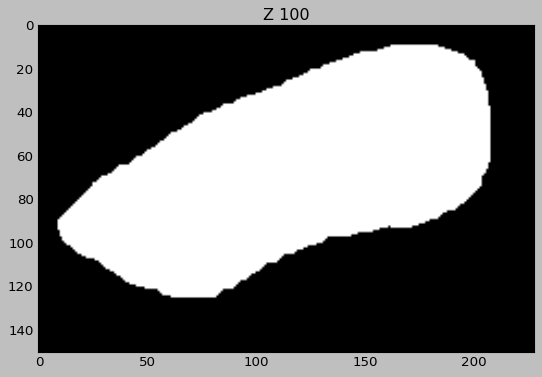

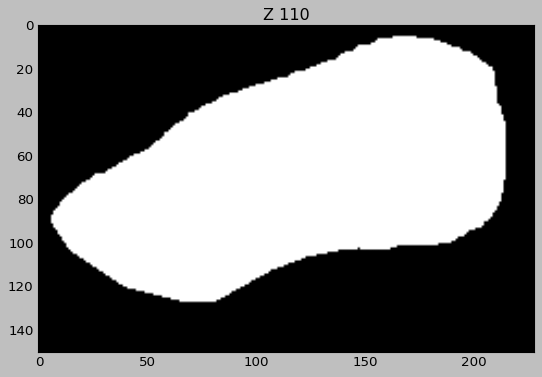

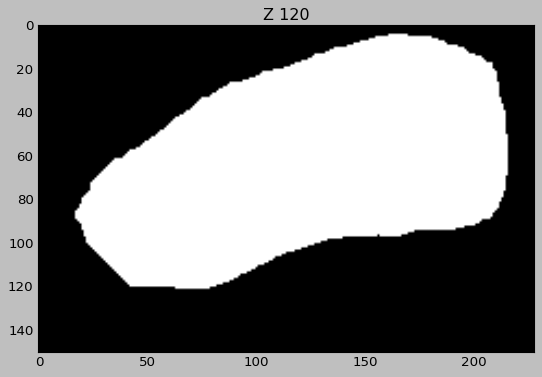

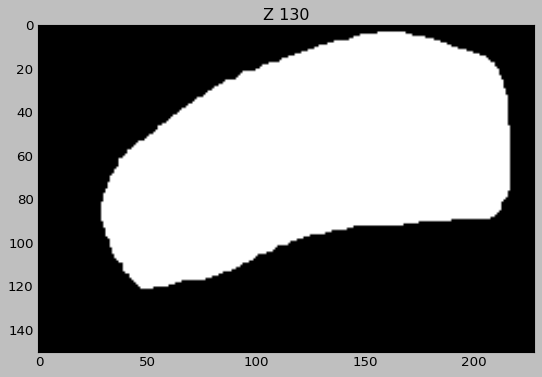

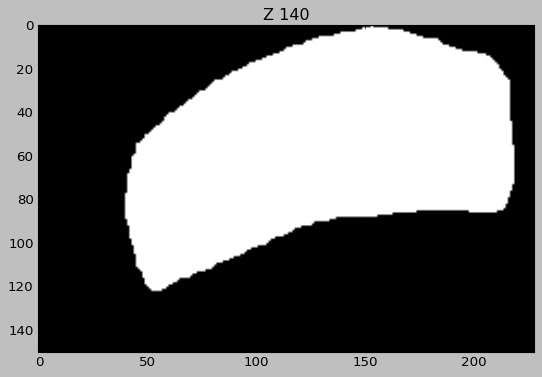

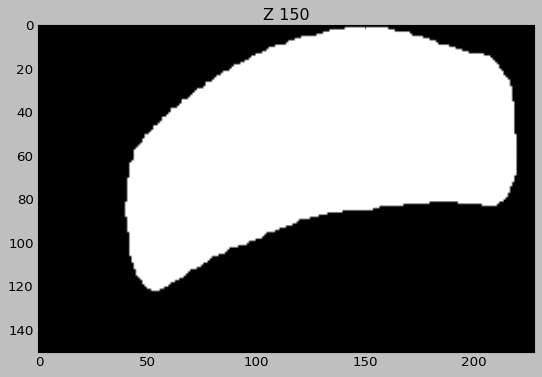

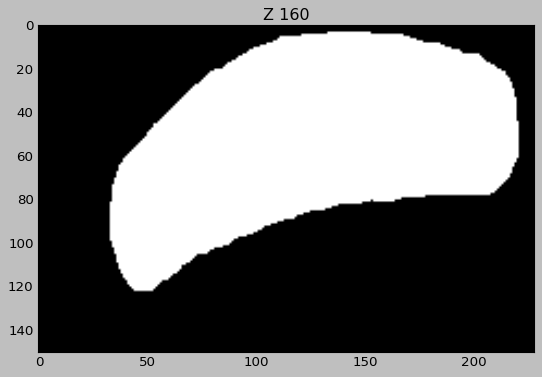

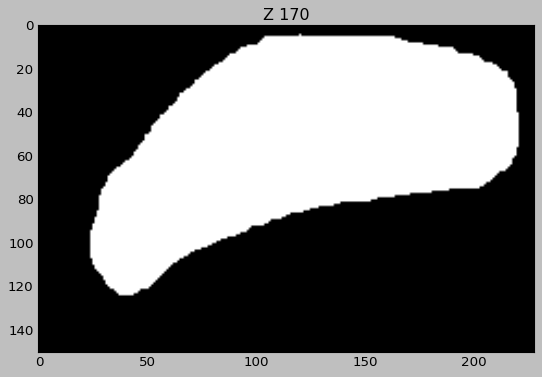

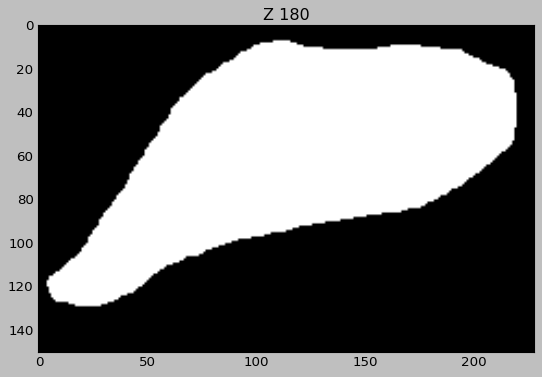

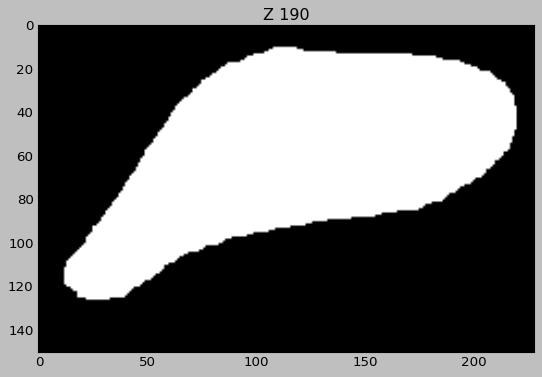

In [12]:
arr = contour
limit = 10
start = (arr.shape[2] // 2) - limit
end = start + limit * 2
nrows = end - start
ncols = 1
plt.style.use('classic')
for i in range(100, 200, 10):
    plt.title('Z {}'.format(i))
    plt.imshow(arr[:,:,i], cmap='gray')
    #plt.imshow(mat, cmap='tab20', interpolation='none')
    plt.show()

In [ ]:
#vm = np.swapaxes(contour, 0, 2)
vm = contour

In [ ]:
zdim = vm.shape[2]
dimensions = neuroglancer.CoordinateSpace(
    names=['z', 'y', 'x'],
    units='um',
    scales=[10,5,5])
viewer = neuroglancer.Viewer()
with viewer.txn() as s:
    s.dimensions = dimensions
    s.layout = '4panel'
    s.layers['Altas'] = neuroglancer.SegmentationLayer(
        source=neuroglancer.LocalVolume(
            data=vm,
            dimensions=dimensions,
            voxel_offset=(0, 0, 0),
        ),
)

print(viewer)

In [ ]:
import pickle
ppath = '/net/birdstore/Active_Atlas_Data/data_root/CSHL_volumes/atlasV9/1um_meanPositions.pkl'
data =  pickle.load( open(ppath, "rb" ) )

In [ ]:
width = 1500
height = 1000
zdim = 400
midx = width // 2
midy = height // 2
midz = zdim // 2

In [ ]:
for k,v in data.items():
    x = v[0] + midx
    y = v[1] + midy
    print(k,x,y, v[0])